# RABI

In [1]:
%load_ext autoreload
%autoreload 2
from FIFOv4 import FIFO
import matplotlib.pyplot as plt
import numpy as np
import math
from spcm import units
import spcm as spcm
import time as time
from time import sleep 
# import API classes into the current namespace
from pulsestreamer import PulseStreamer, Sequence  
import hdawg_driver_latest_v2 as awg
from sg396_driver_v1 import SG396
from pulser import PulseGenerator
from laser_driver import LaserControl
from thorlabs_laser_shutter_driver import LaserShutter

### Connect Instruments

In [2]:
# Digitizer 
FIFO = FIFO('dev/spcm0')

Successfully connected to the digitizer


In [3]:
# Pulse Streamer 
PSch_MW=2
PSch_Digitizer=1 
PSch_Laser= 3
PS_chmap={'mw':PSch_MW,
          'digtrig':PSch_Digitizer,
          'laser':PSch_Laser}
ip = '10.135.70.193' 
ps = PulseGenerator(ip,PS_chmap)
INF = np.iinfo(np.int64).max


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 10.135.70.193
Pulse Streamer 8/2 firmware: v1.5.2
Client software: v1.7.0
Your client software is more up to date than the Pulse Streamer 8/2 firmware. We recommend updating the firmware of your Pulse Streamer 8/2.
For detailed information visit https://www.swabianinstruments.com/pulse-streamer-8-2/downloads/ or contact support@swabianinstruments.com


In [4]:
# AWB
awg = awg.HDAWG('dev8181', '127.0.0.1', 8004)

Trying to connect to dev8181 on interface USB
Connected to dev8181 via data server 127.0.0.1:8004 and interface USB


In [5]:
# Signal Generator 
sg = SG396('TCPIP::10.135.70.65::inst0::INSTR')

connected to SG396 [TCPIP::10.135.70.65::inst0::INSTR]


In [6]:
laser = LaserControl('LAS-08166')
laser_shutter = LaserShutter('68800950')

### Configure Settings

In [7]:
def choose_sideband(opt, nv_freq, side_freq, pulse_axis='x'):
    match pulse_axis:
        case 'y':
            delta = 90
        case _: 
            delta = 0

    match opt:
        case 'Upper':
            frequencies = nv_freq - side_freq
            iq_phases = [delta+90, delta+0]
        case 'Both':
            frequencies = nv_freq - side_freq
            iq_phases = [delta+0, delta+90, delta+90, delta+0] # lower sideband phases + upper sideband phases
        case _:
            frequencies = nv_freq + side_freq
            iq_phases = [delta+0, delta+90]

    return frequencies, iq_phases

In [8]:
import numpy as np


# Define the parameters (as provided)
awg_parameters = {
    "seq": "RABI",
    "i_offset": -2*1e-3, # mV
    "q_offset": -4*1e-3, # mV
    "sideband_power": 450 * 1e-3, # mV
    "sideband_freq": 30*1e6, # MHz
    "iq_phases": [0, 90],
    "num_pts": 100,
    "runs": 100,
    'start': 0,
    'stop': 200*1e-9,
    'mw_times': None,
    'sig_gen_freq': None,
    'pulse_axis': 'y',
    'sideband': 'lower',
    'freq': 2.32*1e6, #from ODMR
    'rf_power' : 500*1e-6,
    'iters': 1000,
    'laser_power':100 } # stay within 300 and 600 uW (generally, but don't exceed 1 mW)

dig_config = {
    'num_pts_in_exp': 2 * awg_parameters['num_pts'], # MW ON + OFF subsequences
    'runs': awg_parameters['runs'], # number of exp. iterations
    'segment_size': 512*1,
    'pretrig_size': 32,
    'readout_ch': int(0),
    'HF_INPUT_50OHM': 1
}

# Calculate sideband frequencies
mw_times = np.linspace(awg_parameters['start'], awg_parameters['stop'], awg_parameters['num_pts']) * 1e9
awg_parameters['mw_times'] = mw_times

In [9]:
sig_gen_freq, iq_phases = choose_sideband(awg_parameters['sideband'], awg_parameters['freq'], awg_parameters['sideband_freq'], awg_parameters['pulse_axis'])

awg_parameters['sig_gen_freq'] = sig_gen_freq
awg_parameters['iq_phases'] = iq_phases

In [10]:
sg.set_frequency(awg_parameters['sig_gen_freq']) # set carrier frequency
sg.set_rf_amplitude(awg_parameters['rf_power']) # set MW power
sg.set_mod_type(7) # quadrature amplitude modulation
sg.set_mod_subtype(1) # no constellation mapping
sg.set_mod_function('IQ', 5) # external modulation
sg.set_mod_toggle(1) # turn on modulation mode

In [11]:
# import ipywidgets as widgets
# from ipywidgets import interactive
# # Create interactive widgets to display the values
# def display_awg_parameters():
#     display(widgets.HTML(value=f"<b>Averaging Sequence: </b>{awg_parameters['seq']}"))
#     display(widgets.HTML(value=f"<b>i_offset: </b>{awg_parameters['i_offset']} mV"))
#     display(widgets.HTML(value=f"<b>q_offset: </b>{awg_parameters['q_offset']} mV"))
#     display(widgets.HTML(value=f"<b>sideband_power: </b>{awg_parameters['sideband_power']} mV"))
#     display(widgets.HTML(value=f"<b>iq_phases: </b>{awg_parameters['iq_phases']}"))
#     display(widgets.HTML(value=f"<b>num_pts: </b>{awg_parameters['num_pts']}"))
#     display(widgets.HTML(value=f"<b>sideband_freqs: </b>{awg_parameters['sideband_freqs']} MHz"))
#     display(widgets.HTML(value=f"<b>runs: </b>{awg_parameters['runs']}"))

#     display(widgets.HTML(value="<br><b>Digitizer Configuration:</b>"))
#     display(widgets.HTML(value=f"<b>num_pts_in_exp: </b>{dig_config['num_pts_in_exp']}"))
#     display(widgets.HTML(value=f"<b>segment_size: </b>{dig_config['segment_size']}"))
#     display(widgets.HTML(value=f"<b>pretrig_size: </b>{dig_config['pretrig_size']}"))
#     display(widgets.HTML(value=f"<b>readout_ch: </b>{dig_config['readout_ch']}"))
#     display(widgets.HTML(value=f"<b>HF_INPUT_50OHM: </b>{dig_config['HF_INPUT_50OHM']}"))

# # Display parameters
# display_awg_parameters()

### Assign Configuration 

In [12]:
print(awg_parameters['i_offset'])
print(awg_parameters['q_offset'])
print(awg_parameters['sideband_power'])
print(awg_parameters['sideband_freq'])
print(awg_parameters['iq_phases'])
print(awg_parameters['mw_times']/1e9)
print(awg_parameters['num_pts'])

-0.002
-0.004
0.45
30000000.0
[90, 180]
[0.00000000e+00 2.02020202e-09 4.04040404e-09 6.06060606e-09
 8.08080808e-09 1.01010101e-08 1.21212121e-08 1.41414141e-08
 1.61616162e-08 1.81818182e-08 2.02020202e-08 2.22222222e-08
 2.42424242e-08 2.62626263e-08 2.82828283e-08 3.03030303e-08
 3.23232323e-08 3.43434343e-08 3.63636364e-08 3.83838384e-08
 4.04040404e-08 4.24242424e-08 4.44444444e-08 4.64646465e-08
 4.84848485e-08 5.05050505e-08 5.25252525e-08 5.45454545e-08
 5.65656566e-08 5.85858586e-08 6.06060606e-08 6.26262626e-08
 6.46464646e-08 6.66666667e-08 6.86868687e-08 7.07070707e-08
 7.27272727e-08 7.47474747e-08 7.67676768e-08 7.87878788e-08
 8.08080808e-08 8.28282828e-08 8.48484848e-08 8.68686869e-08
 8.88888889e-08 9.09090909e-08 9.29292929e-08 9.49494949e-08
 9.69696970e-08 9.89898990e-08 1.01010101e-07 1.03030303e-07
 1.05050505e-07 1.07070707e-07 1.09090909e-07 1.11111111e-07
 1.13131313e-07 1.15151515e-07 1.17171717e-07 1.19191919e-07
 1.21212121e-07 1.23232323e-07 1.25252525e-07

In [13]:
awg.set_sequence(**{'seq': 'Rabi',
                'i_offset': awg_parameters['i_offset'],
                'q_offset': awg_parameters['q_offset'],
                'sideband_power': awg_parameters['sideband_power'],
                'sideband_freq': awg_parameters['sideband_freq'], 
                'iq_phases': awg_parameters['iq_phases'],
                'pi_pulses': awg_parameters['mw_times']/1e9, 
                'num_pts': awg_parameters['num_pts']}) 

AWG COMPILE STATUS:  -1
AWG COMPILE STATUS again:  2
Warning during sequencer compilation:  Compilation started
Detected 1 devices with a total of 1 AWG cores.
Compiling source string
Warning (line: 204): waveform '__playWave_204_300' size 0 is below the minimal waveform length and will be zero-extended to 32 samples
Warning (line: 205): waveform '__playWave_205_301' size 4 is below the minimal waveform length and will be zero-extended to 32 samples
Warning (line: 206): waveform '__playWave_206_302' size 9 is below the minimal waveform length and will be zero-extended to 32 samples
Warning (line: 207): waveform '__playWave_207_303' size 14 is below the minimal waveform length and will be zero-extended to 32 samples
Warning (line: 208): waveform '__playWave_208_304' size 19 is below the minimal waveform length and will be zero-extended to 32 samples
Warning (line: 209): waveform '__playWave_209_305' size 24 is below the minimal waveform length and will be zero-extended to 32 samples
War

In [14]:
FIFO.assign_param(settings_dict=dig_config)
FIFO.config()

SETTINGS: card timeout =  20 s
SETTINGS: # segments =  512 Sa
SETTINGS: sampling freq =  0.5 GHz
SETTINGS: pretrig size =  32 Sa
SETTINGS: termination =  1
50 ohm impedance? 1


### Configure ODMR Pulse Sequence 

In [15]:
import typing as t

In [16]:
_T = t.TypeVar('_T')

def convert_type(arg: t.Any, converter: _T) -> _T:
    return converter(arg)

In [17]:
readout_time = 1000 # ns 
trig_time = 10 #ns 
initial_delay = 100
singlet_decay = 500
laser_time = 15000 # 15 us 
trig_spot = 70 # where this starts 
clock_time = 10 
MW_buffer_time = 100
awg_trig_time = 10

def Rabi(params):
    '''
    Rabi sequence
    '''
    ## Run a MW pulse of varying duration, then measure the signal
    ## and reference counts from NV.
    # self.total_time = 0
    longest_time = convert_type(round(max(params)), float)
    ## we can measure the pi time on x and on y.
    ## they should be the same, but they technically
    ## have different offsets on our pulse streamer.

    def SingleRabi(iq_on):
        '''
        CREATE SINGLE RABI SEQUENCE TO REPEAT THROUGHOUT EXPERIMENT
        '''

        iq_on = float(round(iq_on)) # convert to proper data type to avoid undesired rpyc netref data type

        '''
        DEFINE SPECIAL TIME INTERVALS FOR EXPERIMENT
        '''
        # padding time to equalize duration of every run (for different vsg_on durations)
        # pad_time = 50000 - self.initial_delay - self.laser_time - self.singlet_decay - iq_on - self.MW_buffer_time - self.readout_time 
        pad_time = longest_time - iq_on

        '''
        DEFINE RELEVANT ON, OFF TIMES FOR DEVICES
        '''

        laser_off1 = initial_delay 
        laser_off2 = singlet_decay + iq_on + MW_buffer_time
        laser_off3 = 100 + pad_time
        # laser_off3 = pad_time + self.rest_time_btw_seqs
        # laser_off4 = laser_off2
        # laser_off5 = self.rest_time_btw_seqs

        # mw I & Q off windows
        iq_off1 = laser_off1 + laser_time + singlet_decay
        iq_off2 = (iq_on - awg_trig_time) + MW_buffer_time + readout_time + laser_off3 # + self.laser_time # + laser_off4 + laser_off5

        # Digitizer trigger timing
        clock_off1 = laser_off1 + laser_time + laser_off2 + trig_spot - clock_time
        clock_off2 = - trig_spot + readout_time + laser_off3
                
        '''
        CONSTRUCT PULSE SEQUENCE
        '''


        # define sequence structure for laser            
        laser_seq = [(laser_off1, 0), (laser_time, 1), (laser_off2, 0), (readout_time, 1), (laser_off3, 0)]
                    #  (laser_off3, 0), (self.laser_time, 1), (laser_off4, 0), (self.readout_time, 1), (laser_off5, 0)]
    
        # define sequence structure for DAQ trigger
        dig_clock_seq = [(clock_off1, 0), (clock_time, 1), (clock_off2, 0)]

        # define sequence structure for MW I and Q when MW = ON
        mw_iq_on_seq = [(iq_off1, 0), (awg_trig_time, 1), (iq_off2, 0)]
        mw_iq_off_seq = [(iq_off1, 0), (awg_trig_time, 0), (iq_off2, 0)]

        # assign sequences to respective channels for seq_on
        laser_ps = laser_seq+laser_seq
        dig_ps = dig_clock_seq+dig_clock_seq
        mw_ps = mw_iq_on_seq+mw_iq_off_seq


        return [laser_ps, dig_ps, mw_ps]

    # seqs = Pulser.createSequence()
    laser_ps_tot=[]
    dig_ps_tot=[]
    mw_ps_tot=[]
    for mw_time in params:
        # seqs += SingleRabi(mw_time)
        laser_ps_tot += SingleRabi(mw_time)[0]
        dig_ps_tot += SingleRabi(mw_time)[1]
        mw_ps_tot += SingleRabi(mw_time)[2]

    return [laser_ps_tot, dig_ps_tot, mw_ps_tot]


In [18]:
sequence=Rabi(awg_parameters['mw_times'])

ps.setDigital("laser", sequence[0]) # digitizer trigger
ps.setDigital("digtrig", sequence[1]) # digitizer trigger
ps.setDigital("mw", sequence[2]) # MW IQ
ps.setTrigger
ps.plotSeq(plot_all=False)

In [19]:
FIFO.config()
FIFO.start_buffer()
laser_shutter.open_shutter()
laser.set_modulation_state('pulsed')
laser.set_analog_control_mode('current')
laser.set_diode_current_realtime(awg_parameters['laser_power'])
laser.laser_on()


SETTINGS: card timeout =  20 s
SETTINGS: # segments =  512 Sa
SETTINGS: sampling freq =  0.5 GHz
SETTINGS: pretrig size =  32 Sa
SETTINGS: termination =  1
50 ohm impedance? 1


Failed to set command 'CM=100'
Response from Device :'CM=100.00'


In [20]:
sg.set_rf_toggle(1)
ps.stream(n_runs=INF)
DATA=FIFO.acquire()

(5000, 512, 1)
termination setting: 1.0


In [21]:
FIFO.stop_card()
FIFO.reset()

Card stopped


In [22]:
# copy=[]
# for i in range(0,10):
#     FIFO.config()
#     sg.set_rf_toggle(1)
#     FIFO.start_buffer()
#     DATA=FIFO.acquire()
#     FIFO.stop_card()
#     FIFO.reset()
#     sg.set_rf_toggle(0)
#     copy.append(DATA)

# LASER OFF

In [23]:
#STOP 
ps.reset()
sg.set_rf_toggle(0)
awg.set_disabled()
laser.laser_off()
laser_shutter.close_shutter()
FIFO.reset()

### Data Post Processing

In [24]:
print(np.shape(DATA))
import pandas as pd

(5000, 512, 1)


In [25]:
reshaped_data = DATA.squeeze(axis=2)  # Reduces (20000, 5120, 1) to (20000, 5120)
print(reshaped_data)
data_to_save = pd.DataFrame(reshaped_data)

[[0.09914551 0.09890137 0.09841309 ... 0.1032959  0.10354004 0.10354004]
 [0.09719238 0.09743652 0.09645996 ... 0.10341797 0.1032959  0.10292969]
 [0.09951172 0.1        0.09938965 ... 0.10170898 0.1020752  0.10219727]
 ...
 [0.09755859 0.09707031 0.09780273 ... 0.10256348 0.10256348 0.10268555]
 [0.10170898 0.10146484 0.10109863 ... 0.09963379 0.09975586 0.09890137]
 [0.09951172 0.0987793  0.09914551 ... 0.09707031 0.09780273 0.0979248 ]]


In [26]:
DATA_mean=np.mean(DATA,axis=1)
segments=(np.shape(DATA)[0])


In [27]:
sig=DATA_mean[::2]
bg=DATA_mean[1::2]

In [28]:
ms1_array = np.ones(awg_parameters['num_pts']) # dark data array
ms0_array = np.ones(awg_parameters['num_pts']) # bright data array

for i in range(awg_parameters['num_pts']):
    ms1_array[i] = np.mean(sig[i::awg_parameters['num_pts']])
    ms0_array[i] = np.mean(bg[i::awg_parameters['num_pts']])
    

In [29]:
#MAKE PI PULSE TIME 


In [30]:
np.shape(DATA)

(5000, 512, 1)

[0.10039252 0.10001799 0.10025405 0.09996689 0.10000713 0.10015201
 0.1002171  0.10009413 0.10017133 0.10019588 0.10019174 0.10019935
 0.10021455 0.10013072 0.10016257 0.10032008 0.10018216 0.1002215
 0.10014644 0.10004665 0.10020834 0.10027007 0.10018009 0.10014173
 0.10018956 0.10034694 0.10019041 0.10008181 0.10009854 0.10009377
 0.10031807 0.10022757 0.10035563 0.10020626 0.10010176 0.1002208
 0.1003382  0.10028214 0.10018074 0.10026301 0.10030122 0.10009465
 0.10026074 0.1003017  0.10030754 0.10024375 0.10018241 0.10009166
 0.10037291 0.10015928 0.10007748 0.10020955 0.10024035 0.10020217
 0.10021889 0.10000542 0.10025807 0.10030998 0.10012423 0.10035378
 0.1002434  0.10003484 0.10030458 0.10022554 0.10014905 0.10025025
 0.10023775 0.1001438  0.10018363 0.10035975 0.10026577 0.1000738
 0.1002914  0.10017711 0.10029007 0.10022326 0.1002859  0.10015544
 0.1001848  0.10031762 0.10005237 0.1002285  0.10024225 0.10013597
 0.10024728 0.10037124 0.10012067 0.10030835 0.10023382 0.1000765

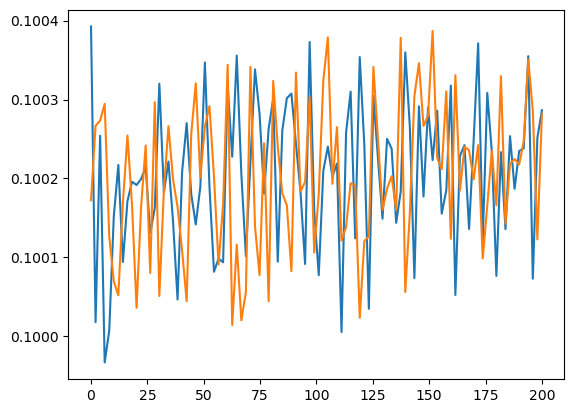

In [31]:
plt.plot(awg_parameters['mw_times'],ms1_array)
plt.plot(awg_parameters['mw_times'],ms0_array)
print(ms1_array)

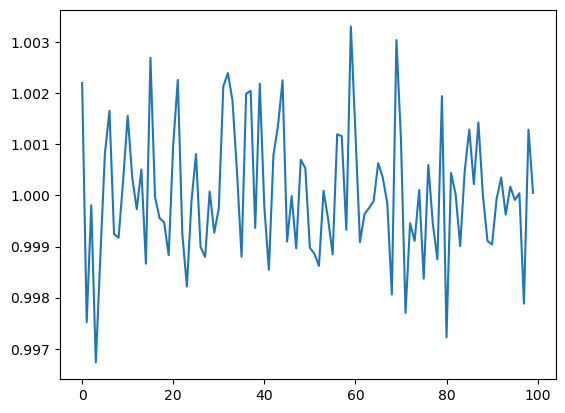

In [32]:
plt.plot(ms1_array/ms0_array)

In [33]:
def contrast_math(data,start,stop):
    sliced_data=data[:, start:stop]
    data_mean=np.mean(sliced_data,axis=1)
    sig=data_mean[::2]
    bg=data_mean[1::2]
    sig_mean=np.zeros(awg_parameters['num_pts'])
    bg_mean=np.zeros(awg_parameters['num_pts'])
    for i in range(awg_parameters['runs']):
        for j in range(0,awg_parameters['num_pts']):
            sig_mean[j]+=np.mean(sig[j::awg_parameters['num_pts']])
            bg_mean[j]+=np.mean(bg[j::awg_parameters['num_pts']])
    return(sig_mean,bg_mean)

def contrast_val(data):
    sig, bg = contrast_math(data)
    max_contrast=np.max((bg-sig)/sig)
    return max_contrast

In [34]:
512*30

15360

In [35]:
sig, bg = contrast_math(DATA,0,512)